In [1]:
from sklearn.naive_bayes import GaussianNB
from datetime import datetime, timedelta
import sklearn.metrics as m
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
input_path = "../data/features_encoded.csv"  # our input file
raw_data = pd.read_csv(input_path, header=0, skiprows=None, index_col=None, delimiter=",")
raw_data

,Unnamed: 0,malicious,length,extension,hostname,tld,isShortened,domainTokenCount,domainTokenLengthAvg,domainTokenLengthStdev,domainTokenLengthMax,pathTokenCount,pathTokenLengthAvg,pathTokenLengthStdev,pathTokenLengthMax
0,0,False,94,0,40,3,0,2,2.500000,0.707107,3,10,7.100000,2.131770,12
1,1,False,40,0,1687,0,0,2,5.000000,2.828427,7,3,8.666667,3.785939,13
2,2,True,48,1,18,0,0,2,6.000000,4.242641,9,5,5.200000,1.923538,8
3,3,False,109,0,110,14,0,2,4.500000,3.535534,7,18,4.111111,2.826115,12
4,4,False,50,1,26560,1,0,2,8.000000,7.071068,13,3,10.000000,8.185353,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,99996,True,131,0,521,2,0,2,4.000000,1.414214,5,32,3.031250,2.007797,8
99997,99997,False,40,1,16262,0,0,2,5.000000,2.828427,7,5,4.800000,2.387467,8
99998,99998,False,56,0,16261,0,0,2,9.500000,9.192388,16,7,4.142857,2.794553,10
99999,99999,False,20,0,36466,29,0,3,5.666667,6.350853,13,0,0.000000,0.000000,0


In [3]:
def parseLine(line):
    label = line["malicious"]
    vector = line[1:]
    vector = np.array(vector, dtype=float)
    return (label, vector)

In [4]:
labelsAndData = raw_data.apply(parseLine, axis=1)
labelsAndData = labelsAndData.apply(pd.Series)
labelsAndData

,0,1
0,False,"[0.0, 94.0, 0.0, 40.0, 3.0, 0.0, 2.0, 2.5, 0.7..."
1,False,"[0.0, 40.0, 0.0, 1687.0, 0.0, 0.0, 2.0, 5.0, 2..."
2,True,"[1.0, 48.0, 1.0, 18.0, 0.0, 0.0, 2.0, 6.0, 4.2..."
3,False,"[0.0, 109.0, 0.0, 110.0, 14.0, 0.0, 2.0, 4.5, ..."
4,False,"[0.0, 50.0, 1.0, 26560.0, 1.0, 0.0, 2.0, 8.0, ..."
...,...,...
99996,True,"[1.0, 131.0, 0.0, 521.0, 2.0, 0.0, 2.0, 4.0, 1..."
99997,False,"[0.0, 40.0, 1.0, 16262.0, 0.0, 0.0, 2.0, 5.0, ..."
99998,False,"[0.0, 56.0, 0.0, 16261.0, 0.0, 0.0, 2.0, 9.5, ..."
99999,False,"[0.0, 20.0, 0.0, 36466.0, 29.0, 0.0, 3.0, 5.66..."


In [5]:
labels = [label for label in labelsAndData[0]]
def boolToInt(b):
    if b: return 1
    return 0
labels = list(map(boolToInt, labels))

In [6]:
def normalizeData(labelsAndData):
    means = labelsAndData.apply(lambda x: x[1], axis=1).mean()
    stdevs = np.sqrt(labelsAndData.apply(lambda x: ((x[1] - means) ** 2), axis=1).mean())
    stdevs[stdevs == 0] = 1
    def normalize(point):
        return (point[0], (point[1] - means) / stdevs)
    return labelsAndData.apply(lambda x: normalize(x), axis=1)

In [7]:
labelsAndDataNorm = normalizeData(labelsAndData)
normalizedData = labelsAndDataNorm.map(lambda x: x[1])
normalizedData = normalizedData.apply(pd.Series)

In [8]:
# 80-20 training-testing split
train = normalizedData[:80000]
test = normalizedData[80000:]
train_labels = labels[:80000]
test_labels = labels[80000:]

In [9]:
gnb = GaussianNB()
gnb.fit(train, train_labels)
predictions = gnb.predict(test)

In [10]:
acc = m.accuracy_score(test_labels, predictions)
prec = m.precision_score(test_labels, predictions)
recall = m.recall_score(test_labels, predictions)
print("Accuracy score: " + str(acc))
print("Precision score: " + str(prec))
print("Recall score: " + str(recall))

Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0


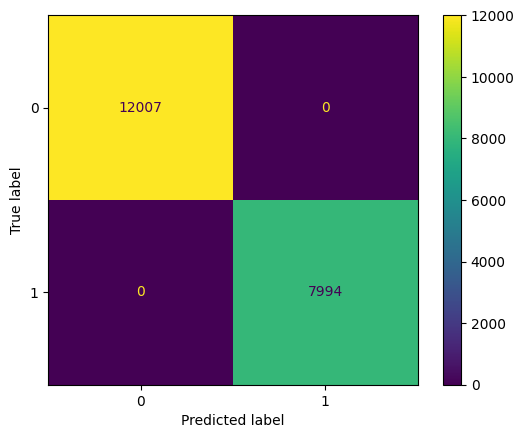

In [11]:
m.ConfusionMatrixDisplay(m.confusion_matrix(test_labels, predictions)).plot()

In [13]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.816507,0.752206,-0.645232,-0.693312,-0.150316,-0.024706,-0.447130,-1.542406,-1.202851,-1.312538,0.725688,0.185049,-0.172525,0.053146
1,-0.816507,-0.457890,-0.645232,-0.536463,-0.183670,-0.024706,-0.447130,-0.445480,-0.525579,-0.535702,-0.523130,0.417441,0.100272,0.113168
2,1.224730,-0.278617,1.549830,-0.695408,-0.183670,-0.024706,-0.447130,-0.006709,-0.074064,-0.147285,-0.166325,-0.096789,-0.206865,-0.186943
3,-0.816507,1.088344,-0.645232,-0.686646,-0.028017,-0.024706,-0.447130,-0.664865,-0.299821,-0.535702,2.152910,-0.258309,-0.058017,0.053146
4,-0.816507,-0.233798,1.549830,1.832273,-0.172552,-0.024706,-0.447130,0.870832,0.828967,0.629551,-0.523130,0.615222,0.825801,0.473302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,1.224730,1.088344,-0.645232,-0.655695,0.094283,-0.024706,-0.447130,-0.006709,0.377452,0.046924,1.617702,-0.175901,-0.190352,-0.246965
79996,1.224730,-0.256208,1.549830,-0.561795,0.016456,-0.024706,0.326740,-1.176764,-0.940917,-0.924120,-0.344728,-0.052288,-0.087762,-0.126921
79997,1.224730,0.662570,-0.645232,-0.664552,0.272172,-0.024706,-0.447130,-1.103635,-0.751336,-0.924120,1.260896,-0.206329,-0.190054,-0.186943
79998,1.224730,-0.614755,1.549830,-0.687408,7.109812,-0.024706,2.648352,-1.469277,-0.992404,-0.924120,-0.701533,-0.497294,-0.174248,-0.427032
